In [111]:
%config IPCompleter.greedy=True

In [363]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
import os
import xgboost
import optuna

# Pandas in practice - Neurofirbromatosis detection

Welcome to the lecture about practical use cases of Pandas library! In this notebook Pandas library was used for ETA and data formatting in real-life research project: usage of Artificial Intelligence for Neurofibromatosis diagnosis based on human genome. Our goal is to develop artificial intelligence system able to classify sick people among healthy ones by interpreting their genetic code. Let's get started!

## Contents of this notebook

- Pandas: EDA (*Exploratory Data Analysis*)
- Pandas: Data I/O, preprocessing and formatting
- Sklearn: Neurofibromatosis detection
- Oputna: automatic hyperparameters tuning

## Libraries required:

- pandas
- numpy
- sklearn
- matplotlib

## Test data creation

Unfortunately, this notebook cannot use original, real data because of protection of sensitive informations and copyrights. So, script below generates dummy csv files which resemble true data. This operation can be skipped

In [113]:
def get_avaliable_genes(number_of_possibilities: int = 1500):
    chromosomes = ["chr" + str(i) for i in range(1, 23)]
    chromosomes.extend(["chrX", "chrY"])

    positions = list(range(1,2000))

    mutations = []
    nucleotydes = ["A", "C", "T", "G"]
    for i in nucleotydes:
        for j in nucleotydes:
            mutations.append(f"{i}/{j}")

    chromosomes = pd.Series(chromosomes)
    positions = pd.Series(positions)
    mutations = pd.Series(mutations)    



    chromosome_choices = np.random.randint(low=0, high=chromosomes.shape, size=number_of_possibilities)
    picked_chromosomes = pd.Series(data=chromosomes.iloc[chromosome_choices])
    picked_chromosomes.index = list(range(picked_chromosomes.shape[0]))

    position_choices = np.random.randint(low=0, high=positions.shape, size=number_of_possibilities)
    picked_positions = positions.iloc[position_choices]
    picked_positions.index = list(range(picked_positions.shape[0]))

    mutation_choices = np.random.randint(low=0, high=mutations.shape, size=number_of_possibilities)
    picked_mutations = mutations.iloc[mutation_choices]
    picked_mutations.index = list(range(picked_mutations.shape[0]))

    options = {
        "chromosome": picked_chromosomes,
        "position": picked_positions,
        "mutation": picked_mutations
    }

    avaliable_options = pd.DataFrame(options)
    return avaliable_options

def get_indicies(amount: int, mean: int, std: int, max_value: int):
    indicies = np.random.randn(amount) * mean + std
    indicies = np.array(indicies, dtype=np.int64)
    indicies = indicies[indicies >= 0]
    indicies = indicies[indicies < max_value]
    return np.unique(indicies)

def create_file_frame(is_healthy: bool, avaliable_options: pd.DataFrame):
    amount = 1000
    mean = int(avaliable_options.shape[0] * 0.5) - 100 if is_healthy else int(avaliable_options.shape[0] * 0.5) + 100
    std = 300 if is_healthy else 600
    indicies = get_indicies(amount, mean, std, avaliable_options.shape[0])
    frame = avaliable_options.iloc[indicies]
    frame.index = list(range(frame.shape[0]))
    
    chr_name = "chr" if is_healthy else "CHROMOSOME"
    pos_name = "pos" if is_healthy else "POSITION"
    mut_name = "mut" if is_healthy else "MUTATION"
    
    frame = frame.rename(columns={"chromosome": chr_name, "position": "pos", "mutation": "mut"})
    
    if is_healthy:
        frame["num_pl_a"] = np.nan
    else:
        frame["is_ok"] = True
        frame["approved_ratio"] = 0.9 
    
    return frame

def create_files(number_of_possibilities: int, healthy: int, sick: int, healthy_folder_path: str, sick_folder_path: str):
    options = get_avaliable_genes()
    for i in range(healthy):
        frame = create_file_frame(True, options)
        frame.to_csv(os.path.join(healthy_folder_path, f"{i}.csv"))
    for i in range(sick):
        frame = create_file_frame(False, options)
        frame.to_csv(os.path.join(sick_folder_path, f"{i}.csv"))

In [107]:
create_files(1500, 60, 42, "healthy", "sick")

# 1. Exploratory Data Analysis (*EDA*)

In this segment we will perform data checks to figure out what type of data we got

In [114]:
path_to_healthy = "healthy"
path_to_sick = "sick"

## Load files

First, we will load csv files representing people suffering from Neurofirbomatosis disease and healthy ones. We will pandas method `read_csv` to create person's dataframe from file. Pandas is able to read alot of different file types, but for the sake of this example we will use csv files.

In [116]:
healthy_people_file_paths = [os.path.join(path_to_healthy, f) for f in os.listdir(path_to_healthy)]
sick_people_file_paths = [os.path.join(path_to_sick,f) for f in os.listdir(path_to_sick)]

df_healthy = [pd.read_csv(f) for f in healthy_people_file_paths]
df_sick = [pd.read_csv(f) for f in sick_people_file_paths]

## Check number of files

Are your classes (healthy, sick) evenly ballanced? It is important to know, because classifiers need to be specially tuned in case of class inbalance. It is a simple check, but it is very effective!

In [207]:
print(f"Number of healthy people: {len(df_healthy)}")
print(f"Number of sick people: {len(df_sick)}")

Number of healthy people: 60
Number of sick people: 42


Turns out that sick people consist only 41% of the dataset. It is not a drastic class inbalance and classifiers should handle it without additional tuning. Nonetheless, it is important to be aware of it!

## Quick peek into the dataframes

We will use two methods: `head` and `tail`. `head` method shows first 5 rows of the dataframe when `tail` shows last 5 rows (methods can be provided with number of rows to be selected). This peek will allow us to quickly build an intuition about data we work with. 

In [208]:
df_healthy[0].head()

,Unnamed: 0,chr,pos,mut,num_pl_a
0,0,chr19,29,A/A,NaN
1,1,chr15,1760,T/G,NaN
2,2,chr14,1032,C/T,NaN
3,3,chr10,1253,T/C,NaN
4,4,chr11,1748,C/A,NaN


In [209]:
df_sick[0].tail()

,Unnamed: 0,CHROMOSOME,pos,mut,is_ok,approved_ratio
477,477,chr22,1419,T/A,True,0.9
478,478,chr6,1612,A/A,True,0.9
479,479,chr11,1987,T/T,True,0.9
480,480,chr15,68,G/G,True,0.9
481,481,chrX,364,C/C,True,0.9


Something interesting! It seems that healthy and sick persons csv files contains different columns! Let's take a look on it in more focused manner.

## Check columns

First, let's check what columns are in every file and group. To do this we will use dataframe fields `columns` and `dtypes`. Also, we will use `groupby` function to get unique columns and `describe` to summarize results of our operations.

In [210]:
def check_column_types(df_list: list) -> pd.DataFrame:
    d = {
        "column": [],
        "type":[]
    }
    for df in df_list:
        for i in range(len(df.columns)):
            d["column"].append(df.columns[i])
            d["type"].append(df.dtypes[i])
    
    df = pd.DataFrame(d)
    df = df.groupby("column")
    return df

In [211]:
healthy_person_columns = check_column_types(df_healthy)
healthy_person_columns.describe()

type                     
           count unique      top freq
column                               
Unnamed: 0    60      1    int64   60
chr           60      1   object   60
mut           60      1   object   60
num_pl_a      60      1  float64   60
pos           60      1    int64   60

In [212]:
sick_person_columns = check_column_types(df_sick)
sick_person_columns.describe()

type                     
               count unique      top freq
column                                   
CHROMOSOME        42      1   object   42
Unnamed: 0        42      1    int64   42
approved_ratio    42      1  float64   42
is_ok             42      1     bool   42
mut               42      1   object   42
pos               42      1    int64   42

Ok, so what do we got?

Healthy persons csvs contain classes: "Unnamed: 0", "chr", "mut", "num_pl_a", "pos" and sick persons csvs contain classes:  "CHROMOSOME", "Unnamed: 0", "approve_ratio", "is_ok", "mut", "pos".

It means that these csv files are of different format and we need more details to know how to combine those two groups. We also know, what type of fileds are stored in these columns (strings are considered `object`s in pandas) and that in each column there is only one datatype (columns `count` and `type freq` are equal to eachother).

## Time to ask questions to person, who knows context of this data

As a Data Scientists, we know how to operate on data, but we often don't know the context behind the data. These csv files has been given to us by scientist in the field of Biology. She knows what each column really means, so it is time to ask her a few questions:

- Are columns `chr` and `CHROMOSOME` equivalents of each other?
- What columns are essential to encode genetic mutation?

### Getting ansers back

- Yes, columns `chr` and CHROMOSOME are equivalents of each other
- We need 'chr', 'pos' and 'mut'

Good. We can proceed then!

## Unify the DataFrames: Filter out unnecessary rows

The intersection of sets of columns of healthy and sick persons are {'chr' <-> 'CHROMOSOME', 'pos', 'mut'}. It seems like for now no other column is needed, so let's take them.

To do that we will use operation: `df[["first_column_to_take_name', "second_column_to_take_name"...]]`. It allows to take from DataFrame only these columns, that we specify. If we are to take only one column, then resulting object would be type `pd.Series`, but in this example we will use multiple columns, so it will be of type `pd.DataFrame`.

Let's filter out!

In [213]:
df_healthy_filtered = [df[["chr", "pos", "mut"]] for df in df_healthy]
df_sick_filtered = [df[["CHROMOSOME", "pos", "mut"]] for df in df_sick]

Quick check, if that worked:

In [214]:
df_healthy_filtered[0].head()

,chr,pos,mut
0,chr19,29,A/A
1,chr15,1760,T/G
2,chr14,1032,C/T
3,chr10,1253,T/C
4,chr11,1748,C/A


In [215]:
df_sick_filtered[0].head()

,CHROMOSOME,pos,mut
0,chr18,1597,G/A
1,chr19,29,A/A
2,chr7,1960,G/T
3,chr13,514,C/A
4,chr22,1792,G/G


## Unify the DataFrames: rename columns

There is one column that encodes the same data, yet it has different name in each of sets: "chr" in healthy persons group and "CHROMOSOME" in sick ones. That is not good! Because of that, we can't merge these dataframes together, perform any complicated operation and we have to constantly remember where each version of column goes. 

Solution is simple: rename the column in one set.

Let's rename "CHROMOSOME" in sick person gropu to "chr". To do that we will use function `rename`.

In [216]:
df_sick_filtered = [df.rename(columns={"CHROMOSOME": "chr"}) for df in df_sick_filtered]

Let's see if that worked:

In [217]:
df_sick_filtered[0].head()

,chr,pos,mut
0,chr18,1597,G/A
1,chr19,29,A/A
2,chr7,1960,G/T
3,chr13,514,C/A
4,chr22,1792,G/G


## Check how much rows are there in each file

We know a thing or two regarding files columns, but what about rows count? Let's find out!

In [218]:
def get_rows_statistics(dfs: list) -> None:
    counts = [df.shape[0] for df in dfs]
    counts = np.array(counts)
    
    return {
        "sum": counts.sum(),
        "mean": counts.mean(),
        "min": counts.min(),
        "max": counts.max(),
        "std": counts.std()
    }

In [219]:
get_rows_statistics(df_healthy_filtered)

{'sum': 30495,
 'mean': 508.25,
 'min': 481,
 'max': 539,
 'std': 13.796889746122735}

In [220]:
get_rows_statistics(df_sick_filtered)

{'sum': 21187,
 'mean': 504.45238095238096,
 'min': 481,
 'max': 532,
 'std': 11.613215749539465}

## Merge dataframes in one big dataframe

Now, when we have uniformed dataframes we want to make some statistics regarding values stored in `chr`, `pos` and `mut` columns. To do it, first we need to merge all these 100 small dataframes in one, big dataframe.

To do that we will use function `concat` with parameter `axis` equal to 0. Function `concat` concatenates one dataframe to another. `axis` parameter determines which axes will be concatenated. 0 means "concatenate rows of the second dataframe below rows of the first dataframe" when 1 means "concatenate columns of the second dataframe after columns of the first dataframe".

In [221]:
df_hs = pd.concat([*df_healthy_filtered, *df_sick_filtered], axis=0)

Let's see if that worked:

In [222]:
df_hs.head(1)

,chr,pos,mut
0,chr19,29,A/A


In [223]:
df_hs.shape

(51682, 3)

In [224]:
np.array([df.shape[0] for df in [*df_healthy_filtered, *df_sick_filtered]]).sum()

51682

Works fine! It has three columns (as we wanted) and as many rows as all the rows from all the dataframes. So it is a valid concatenation. We can proceed.

## Get unique values for each column

We have all the data in one, neat dataframe. It is time to check how many unique values are there in each column. To do it we will use `unique` funciton.

In [225]:
chr_unique = df_hs["chr"].unique()
chr_unique.shape

(24,)

In [226]:
pos_unique = df_hs["pos"].unique()
pos_unique.shape

(1063,)

In [227]:
mut_unique = df_hs["mut"].unique()
mut_unique.shape

(16,)

Okay, so now we know that there are 24 different pairs of chromosomes in the set, there are 1063 unique positions and 16 different mutaiton types. That's awesome... WAIT!

### Is there something wrong with the data?

Yes, it is! Humans have only 23 different pairs of chromosomes! Strange... let's see what values are there:

In [228]:
chr_unique

array(['chr19', 'chr15', 'chr14', 'chr10', 'chr11', 'chr1', 'chr16',
       'chrY', 'chr7', 'chrX', 'chr22', 'chr20', 'chr4', 'chr6', 'chr8',
       'chr9', 'chr18', 'chr5', 'chr13', 'chr3', 'chr2', 'chr12', 'chr21',
       'chr17'], dtype=object)

What a mess.. let's order them alphabetically:

In [229]:
np.sort(chr_unique)

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX', 'chrY'], dtype=object)

Okay, these files clearly have chromosomes: from chr1 to chr22 plus chrX and chrY. We found an error in the data, but what values are bad?

## Time to ask questions to person, who knows context of this data

Question is simple: "what's going on with these data?"
Answer from the person, who knows the data: "Hmmm... it seams that the company we hired to get that data made a blunder. Thanks! Now we know, to never hire them again! About these chromosomes... just get rid of any row that has chr="chr22"."

Okay! It's time to perform filtering then!

## Get rows that satisfies boolean condition

If pandas dataframe will get in it's square parenthesis series of boolean values (True, False, False, True...) it will return Dataframe containing rows which corresponding position of input series had True value. So, let's do the filtering!

In [230]:
df_hs = df_hs[df_hs["chr"] != "chr22"]

Quick check:

In [231]:
chr_unique = df_hs["chr"].unique()
chr_unique.shape

(23,)

In [232]:
np.sort(chr_unique)

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX',
       'chrY'], dtype=object)

Outstanding! It worked! But wait... we need to update rows statistics now!

In [233]:
df_healthy_filtered = [df[df["chr"] != "chr22"] for df in df_healthy_filtered]
df_sick_filtered = [df[df["chr"] != "chr22"] for df in df_sick_filtered]

In [234]:
get_rows_statistics(df_healthy_filtered)

{'sum': 29170,
 'mean': 486.1666666666667,
 'min': 460,
 'max': 513,
 'std': 13.309353436169951}

In [235]:
get_rows_statistics(df_sick_filtered)

{'sum': 20296,
 'mean': 483.23809523809524,
 'min': 462,
 'max': 510,
 'std': 10.960555955245725}

## Get histogram of values apperance

We know how many unique values are in each column. Now, we would like to know, how often each of them appears. Let's make the histograms!

<AxesSubplot:>

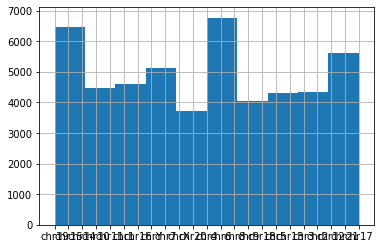

In [236]:
df_hs["chr"].hist()

Yup... super-readable... Jupyter Notebooks limitations are limiting. Nonetheless, we can assume that distribution of chromosomes is uniform-ish.

<AxesSubplot:>

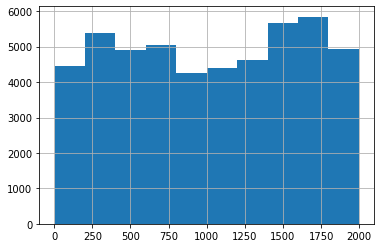

In [237]:
df_hs["pos"].hist()

Problem... `pos` column contains integer objects, so Pandas aggregates them in integer bins instead of treating them like unique values. Let's convert them to strings before making a histogram and see how it will works!

<AxesSubplot:>

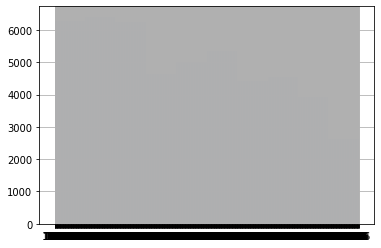

In [238]:
df_hs["pos"].astype(str).hist()

Oh, well... maybe an integer histogram wasn't that bad after all? Again, distribution is uniform-ish

<AxesSubplot:>

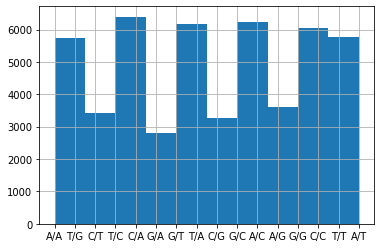

In [239]:
df_hs["mut"].hist()

That is a nice histogram! Okay, we see that some values are less frequent than others, but again, there is no distribution better representing these data than uniform, so the verdict is: uniform-ish.

## How many unique pairs and triplets are there?

Okay, so what do we know so far?

- There are 23 different chromosomes
- There are 1063 different positions
- There are 16 different mutations

Now, if these values are independent of each other then we have 23 * 1063 * 16 = 391.184 unique triplets! That is NOT GOOD! If this is true, then we have two options:

- One-hot encoding for existance of every possible triplets in the file. Now, average healthy person file contains 486 rows and average sick person files contains 483 rows. Let's say on average every one of them has 485 rows to make calculations easier. It would mean, that this one-hot encoded vector contains only around 0.12% of ones and rest is zeros. That is VERY NOT GOOD. Such inbalance of values may prove to be very difficult for classifier to learn.
- Embedding layers. Ach, yes. Embedding layers! Magical layers allowing us to treat symbolic features like computable vectors. They are wonderful featues, but... if you can not use them, don't use them. They are a bit specific and complicated, when the taks seems to be quite easy. It's just a binary classification after all! Also, if we use embedding layers, then out of the blue we have to ensure that triplets will appear in the same order, so each triplet would meet weights of FC layers designed to train them. It would probably mean some complicated neural network architecture like Time-Delay Neural Network, Convolutional Neural Network or even LSTM Network! Again, it is a binary classification task after all!

So before we start to panic about difficultiness of the task, let's see if chromosomes, positions and mutations are truly independent from each other.

In [240]:
chr_pos = df_hs.groupby(["chr", "pos"])
chr_pos.count().sort_values("mut", ascending=[0])

,,mut
chr,pos,
chrX,842,92
chrY,1149,91
chr13,1407,86
chrX,1767,85
chr2,308,84
...,...,...
chr11,1613,11
chr21,784,11
chr7,1166,10


Not so bad! There are only 1407 unique pairs of chr and pos instead of 23 * 1063 = 24.449! Moreover, it seems that there are more probable pairs (chrX + 842 with frequency of 92) than others (chr21 + 536). Let's check more!

In [241]:
chr_mut = df_hs.groupby(["chr", "mut"])
chr_mut.count().sort_values("pos", ascending=[0])

pos
chr   mut     
chr16 A/G  393
chr2  C/C  342
chr7  G/T  342
      C/G  321
chr6  C/C  319
...        ...
chr9  C/T   19
chrY  C/C   18
chr3  A/T   18
chr21 C/T   16
chr12 C/A   14

[361 rows x 1 columns]

Well... not so good here. 361 vs. 23 * 16 = 368

In [242]:
pos_mut = df_hs.groupby(["pos", "mut"])
pos_mut.count().sort_values("chr", ascending=[0])

,,chr
pos,mut,
509,T/T,94
1794,C/T,93
1360,C/T,91
1203,A/G,87
609,A/T,82
...,...,...
784,C/A,11
62,C/T,11
1166,C/G,10


1407 vs. 1063 * 16 = 17.008. Not bad! Now, let's check how many unique triplets are there.

In [243]:
unique = df_hs.groupby(["chr", "pos", "mut"])
len(unique)

1434

Wow!... Only 1434 unique triplets instead of over 300 thousands! Not bad. Not bad at all! Now... we need a histogram of they apperance

In [247]:
df_hs["freq"] = 0
unique = df_hs.groupby(["chr", "pos", "mut"])
unique = unique.count().sort_values("freq", ascending=[0])
unique

freq
chr   pos  mut      
chr18 1597 G/A    62
chr8  1204 T/C    56
      1712 C/G    55
chr16 1685 A/G    54
chr10 609  A/T    53
...              ...
chr17 62   C/T    11
chr21 784  C/A    11
      536  G/G    10
chr7  1166 C/G    10
chr21 1733 A/C     9

[1434 rows x 1 columns]

Not bad, not bad. Now it is time to get some statistics on how often these triplets appear

In [248]:
freqs = unique["freq"].to_numpy()

print(f"Average: {freqs.mean()}, Min: {freqs.min()}, Max: {freqs.max()}, Std: {freqs.std()}")

Average: 34.49511854951186, Min: 9, Max: 62, Std: 9.415944881553063


How about quickly plotting a histogram?

(array([ 29.,  88., 141., 188., 237., 310., 327., 104.,   9.,   1.]),
 array([ 9. , 14.3, 19.6, 24.9, 30.2, 35.5, 40.8, 46.1, 51.4, 56.7, 62. ]),
 <BarContainer object of 10 artists>)

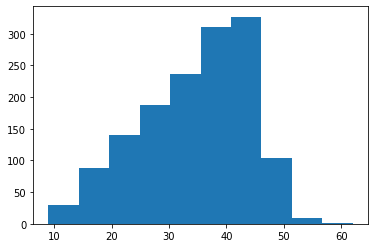

In [249]:
plt.hist(freqs)

Okay, now we know quite a lot about our data! Let's save for later then:

In [251]:
unique.to_csv("histogram.csv")

Awesome! Now, let's check how often each of these pairs appears in healthy and sick people

In [256]:
dfh = pd.concat(df_healthy_filtered, axis=0)
dfs = pd.concat(df_sick_filtered, axis=0)

dfh["freq"] = 0
dfh.groupby(["chr", "pos", "mut"]).count().sort_values("freq", ascending=[0]).to_csv("healthy_histogram.csv")

dfs["freq"] = 0
dfs.groupby(["chr", "pos", "mut"]).count().sort_values("freq", ascending=[0]).to_csv("sick_histogram.csv")

Okay! So we have histograms of healthy and sick people. Now let's merge them, to see what triplets are common among all groups, whic are group specific and which are irrelevant for every group.

In [261]:
healthy_hist = pd.read_csv("healthy_histogram.csv")
healthy_hist = healthy_hist.rename(columns={"freq": "healthy_freq"})

sick_hist = pd.read_csv("sick_histogram.csv")
sick_hist = sick_hist.rename(columns={"freq": "sick_freq"})

merged = healthy_hist.merge(sick_hist, on=["chr", "pos", "mut"], how="outer")
merged["freq"] = merged["healthy_freq"] + merged["sick_freq"]
merged.sort_values("freq", ascending=[0])
merged.to_csv("healthy_sick_histogram.csv")

We finished EDA! So, what did we learned?

- There are columns name mismatch between healthy and sick ones. We corrected it
- There is an error in data. Rows may contain non-existing chr22. We cleaned it.
- Typical file has around 485 triplets, when there are 1434 unique triplets in whole set. It means, that if we encode file using one-hot encoding it will contain around 34% ones. That's awesome! It means that we can use it and our cliassifiers can be simple one.

Let's use that knowledge to encode data for a classifier!

# 2. Data encoding

In this segment we will convert csv files of healthy and sick people so the machine learning classifier will be able to distinguish between healthy and sick people. Thanks to EDA, we know, that we can one-hot encode triplets. Let's get started!

Load histogram:

In [318]:
hist = pd.read_csv("histogram.csv")

Here we can filter out histogram to get rid of values that occur rarely, or maybe to exclude values that are to uniformly spread between healthy and sick alike. For now we won't do it, but it is good to remember about it.

Take only these colmuns, that encode gene:

In [319]:
hist = hist[["chr", "pos", "mut"]]

Load csvs:

In [320]:
def load(path: str) -> list:
    file_paths = [os.path.join(path, f) for f in os.listdir(path)]
    return [pd.read_csv(f) for f in file_paths]

In [321]:
dfh = load("healthy")
dfs = load("sick")

Rename "CHROMOSOME" row in sick csvs for "chr"

In [322]:
dfs = [df.rename(columns={"CHROMOSOME": "chr"}) for df in dfs]

Take only useful rows ("chr", "pos", "mut")

In [323]:
dfh = [df[["chr", "pos", "mut"]] for df in dfh]
dfs = [df[["chr", "pos", "mut"]] for df in dfs]

Add column "exists" = 1

In [324]:
for df in [*dfh, *dfs]:
    df["exists"] = 1

Now, we want to perform one-hot encoding. It means that, we want to check for every triplet in histogram if such a triplet exists in the file. To speed up this process we will use left-join on histogram and file's dataframe and check "exist" column. If triplet exists in file, then "exist" column will have 1. If not, then Nan. Let's see how it worked on one frame:

In [325]:
hist.merge(dfh[0], on=["chr", "pos", "mut"], how="left")

,chr,pos,mut,exists
0,chr18,1597,G/A,NaN
1,chr8,1204,T/C,1.0
2,chr8,1712,C/G,1.0
3,chr16,1685,A/G,NaN
4,chr10,609,A/T,1.0
...,...,...,...,...
1429,chr17,62,C/T,NaN
1430,chr21,784,C/A,NaN
1431,chr21,536,G/G,NaN
1432,chr7,1166,C/G,NaN


Not bad! However, Nan means nothing for classifier, so we have to convert them to zeros. Let's check now:

In [274]:
hist.merge(dfh[0], on=["chr", "pos", "mut"], how="left").fillna(0)

,chr,pos,mut,exists
0,chr18,1597,G/A,0.0
1,chr8,1204,T/C,1.0
2,chr8,1712,C/G,1.0
3,chr16,1685,A/G,0.0
4,chr10,609,A/T,1.0
...,...,...,...,...
1429,chr17,62,C/T,0.0
1430,chr21,784,C/A,0.0
1431,chr21,536,G/G,0.0
1432,chr7,1166,C/G,0.0


Much better! So, let's encode them!

In [331]:
def encode(hist: pd.DataFrame, df: pd.DataFrame):
    return hist.merge(df, on=["chr", "pos", "mut"], how="left").fillna(0)["exists"].to_numpy()

In [332]:
dfh_encoded = [encode(hist,df) for df in dfh]
dfs_encoded = [encode(hist,df) for df in dfs]

Wonderful! We have collections of numpy arrays containing one-hot encoded vectors for each file. It is time to create lables for each of this vector. We detect Neurofibromatosis, so if someone is sick, then he or she should have label 1 and if not then 0.

In [334]:
dfh_labels = np.zeros(len(dfh_encoded))
dfs_labels = np.ones(len(dfs_encoded))

Great! Now, classifiers, which we will use wants to be provided two matrixies: one containing data (one-hot encoded vectors) and one containing labels. It means that, we have to transofrm list of one-hot encoded vectors into one big matrix. Let's go:

We will want to concatenate these vectors by axis = 0, but first we have turn them from 1D vectors of shape 1434 to 2D vectors of shape (1, 1434), so numpy will be able to concat them by first axis:

In [335]:
vectors = [*dfh_encoded, *dfs_encoded]
vectors = [v.reshape(1,-1) for v in vectors]

Time to concatenate them!

In [336]:
X = np.concatenate(vectors, axis=0)
X.shape

(102, 1434)

Outstanding! Now, concatenate labels:

In [337]:
Y = np.concatenate([dfh_labels, dfs_labels], axis=0)
Y.shape

(102,)

Almost done! There is only one more thing to do: shuffle them. Why? Right now there are 60 healthy people in the row and after that there are 42 sick people. It may cause classifier to overfit, so we want to shuffle them to prevent it.

In [338]:
indicies = np.arange(labels.shape[0])
np.random.shuffle(indicies)
X = X[indicies, :]
Y = Y[indicies]

Hooray! We have matricies encoded and shuffled! One last thing to do is to divide X, Y into train, validation and test datasets. Let's say: 60% of data for training, 20% for validation and 20% for testing. Let's go:

In [339]:
train_stop = int(Y.shape[0] * 0.6)
val_stop = train_stop + int(Y.shape[0] * 0.2)

train_x = X[:train_stop, :]
val_x = X[train_stop: val_stop, :]
test_x = X[val_stop:, :]

train_y = Y[:train_stop]
val_y = Y[train_stop: val_stop]
test_y = Y[val_stop]

We did it! Data are ready to be filled into the classifiers. Let's go to the third step.

# 3. Neurofibromatosis detection

We have performed *Exploratory Data Analysis* and encoded data based on its results. Now it is time to get down with the sickness (Ow-aaaaa!)

Here is a list of classifiers, we will try to classify patients:

- SVM (*Support Vector Machine*)
- Random Forest
- XGBoost

We will train classifiers on training data and evaluate them on validation data. The best one will be then tested on test data as a final result of our studies. For evaluation we will use two commonly used metrics: accuracy and F1. Accuracy depicts how often model was right. F1 score on the other hand is harmonic average between precision and recall. Without diving any deeper in the subject let's just say, that F1 is good metric to determine if model does not favorize one class over another.

Let's get started!

In [356]:
def evaluate(model):
    model.fit(train_x, train_y)
    train_pred = model.predict(train_x)
    
    train_acc = accuracy_score(train_y, train_pred)
    train_f1 = f1_score(train_y, train_pred, average=None)
    
    print(f"Training: acc: {train_acc}, f1: {train_f1}")
    
    val_pred = model.predict(val_x)
    
    val_acc = accuracy_score(val_y, val_pred)
    val_f1 = f1_score(val_y, val_pred, average=None)
    
    print(f"Validation: acc: {val_acc}, f1: {val_f1}")

In [357]:
# Using SVM

evaluate(SVC())

Training: acc: 1.0, f1: [1. 1.]
Validation: acc: 0.65, f1: [0.78787879 0.        ]


In [358]:
# Using Random Forest

evaluate(RandomForestClassifier())

Training: acc: 1.0, f1: [1. 1.]
Validation: acc: 0.65, f1: [0.77419355 0.22222222]


In [375]:
# Using XGBoost

evaluate(xgboost.XGBClassifier())

Training: acc: 1.0, f1: [1. 1.]
Validation: acc: 0.65, f1: [0.72       0.53333333]


Not good... Well, that is not suprising, to be honest. There are barely 60 samples of data. This is very, very small amount. Unfortunately, we won't get more, so let's try to accually do seomthing with it. Altghough every classifier got 65% accuracy, XGBoost scored the best f1 score on two classes combined, so we will take XGBoost for tuning and see, if we will be able to produce better results.

# 4. Automatic classifier tuning with Optuna library

In this point we will try to fine-tune xgboost using Optuna library for automatic optimization. We will try to find better results, by modifying these parameters:

- maximum tree depth
- number of estimators
- amount of rows to be seen by one tree
- regularization lambda parameter
- cut-off parameter

Let's get started

In [386]:
def _objective(trial) -> float:
    max_depth = trial.suggest_int("max_depth",low=3,high=12)
    n_estimators = trial.suggest_int("n_estimators",10,500)
    reg_lambda = trial.suggest_loguniform("reg_labda", 0.1, 10.0)
    subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
    p = trial.suggest_uniform("cut-off parameter", 0.1, 0.9)
    xgb = xgboost.XGBClassifier(max_depth = max_depth, n_estimators=n_estimators, 
                               reg_lambda=reg_lambda, subsample=subsample)
    xgb = xgboost.XGBClassifier()
    
    xgb.fit(train_x, train_y)
#     pred = xgb.predict_proba(val_x)
#     pred = softmax(pred)[:,1]
#     pred = pred > p
#     pred = pred.astype(int)
    
    f1 = min(f1_score(val_y, xgb.predict(val_x), average=None))
    return f1

In [ ]:
os.remove("optuna.db")
study = optuna.create_study(study_name="xgboost for neurofibromatosis classification test",
                            storage="sqlite:///optuna.db",
                            load_if_exists=False)
study.optimize(_objective, n_trials=1000)

Well... nothing helps. Overfitting is too strong. So, if we are not able to get more data or fine-tune model, then we should try remove some of the featues

# 5. Back to EDA

Let's try taking less features in order to prevent such strong overfitting. To do it, we have to analyse healthy_sick_histogram.

In [390]:
hist = pd.read_csv("healthy_sick_histogram.csv")
hist.sort_values("sick_freq", ascending=[0])

,Unnamed: 0,chr,pos,mut,healthy_freq,sick_freq,freq
118,118,chr8,1204,T/C,30,26,56
575,575,chr20,1292,A/C,24,24,48
597,597,chr5,668,A/T,24,24,48
69,69,chr8,1712,C/G,31,24,55
947,947,chr2,1848,C/A,17,23,40
...,...,...,...,...,...,...,...
1106,1106,chrY,372,G/C,14,6,20
1360,1360,chr6,1446,C/A,7,6,13
1077,1077,chr6,1612,A/A,14,5,19
1416,1416,chr21,1733,A/C,4,5,9


Let's try adding column which depicts difference between sick and healthy

In [391]:
hist["diff"] = hist["sick_freq"] / hist["healthy_freq"]

In [392]:
hist.sort_values("diff", ascending=[0])

,Unnamed: 0,chr,pos,mut,healthy_freq,sick_freq,freq,diff
1433,1433,chr17,62,C/T,1,10,11,10.000000
1430,1430,chr1,570,A/T,3,14,17,4.666667
1432,1432,chr16,72,C/T,3,13,16,4.333333
1428,1428,chr14,341,T/G,3,13,16,4.333333
1427,1427,chr18,627,C/T,3,12,15,4.000000
...,...,...,...,...,...,...,...,...
255,255,chr5,1985,C/T,28,8,36,0.285714
28,28,chr15,1987,T/A,33,9,42,0.272727
512,512,chr9,1527,T/C,24,6,30,0.250000
131,131,chr1,1298,A/A,30,7,37,0.233333


Ok then... how many are there genes, that are more than 2 times more likely in sick group instead of healthy ones?

In [393]:
hist[hist["diff"] > 2].shape

(35, 8)

How about 1.5?

In [394]:
hist[hist["diff"] > 1.5].shape

(108, 8)

Not bad. Let's try to use such hist to encode data

In [395]:
hist = hist[hist["diff"] > 1.5]

In [396]:
dfh = load("healthy")
dfs = load("sick")
dfs = [df.rename(columns={"CHROMOSOME": "chr"}) for df in dfs]
dfh = [df[["chr", "pos", "mut"]] for df in dfh]
dfs = [df[["chr", "pos", "mut"]] for df in dfs]
for df in [*dfh, *dfs]:
    df["exists"] = 1
dfh_encoded = [encode(hist,df) for df in dfh]
dfs_encoded = [encode(hist,df) for df in dfs]
dfh_labels = np.zeros(len(dfh_encoded))
dfs_labels = np.ones(len(dfs_encoded))
vectors = [*dfh_encoded, *dfs_encoded]
vectors = [v.reshape(1,-1) for v in vectors]
X = np.concatenate(vectors, axis=0)
Y = np.concatenate([dfh_labels, dfs_labels], axis=0)
indicies = np.arange(labels.shape[0])
np.random.shuffle(indicies)
X = X[indicies, :]
Y = Y[indicies]
train_stop = int(Y.shape[0] * 0.6)
val_stop = train_stop + int(Y.shape[0] * 0.2)

train_x = X[:train_stop, :]
val_x = X[train_stop: val_stop, :]
test_x = X[val_stop:, :]

train_y = Y[:train_stop]
val_y = Y[train_stop: val_stop]
test_y = Y[val_stop]

In [397]:
# Using SVM

evaluate(SVC())

Training: acc: 1.0, f1: [1. 1.]
Validation: acc: 1.0, f1: [1. 1.]


Wow! The simplest of classifiers was able to have PERFECT performance. What with the rest of classifiers?

In [398]:
# Using Random Forest

evaluate(RandomForestClassifier())

Training: acc: 1.0, f1: [1. 1.]
Validation: acc: 0.8, f1: [0.85714286 0.66666667]


In [399]:
# Using XGBoost

evaluate(xgboost.XGBClassifier())

Training: acc: 1.0, f1: [1. 1.]
Validation: acc: 0.7, f1: [0.8 0.4]


That's suprising to be honest, but only slightly. You see... there are three rules of thumb to consider, when we deal with overfitting:

- increase number of data acquired
- simplify the model
- reduce amount of features

In other words, make it harder for model to "learn by heart" training dataset. 

That's all for today. Have a nice day :)